# 1D and 2D Fast Haar Transform

Adapted from Gabriel Peyré's http://www.numerical-tours.com/

This notebook aims to familiarize you with the Fast Wavelet Transform algorithm.

In [320]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.data import astronaut
from skimage.transform import resize
from skimage.color import rgb2gray

## 1-D Haar transform

The Haar transform is the simplest orthogonal wavelet transform. It is computed by iterating difference and averaging between odd and even samples of the signal.

### Generating a 1-D signal

First, let's generate a piecewise-regular 1-D signal $f\in\mathbb R^n$ to play with.

In [321]:
# Define the size of our signal.
n = 2**9 # 512

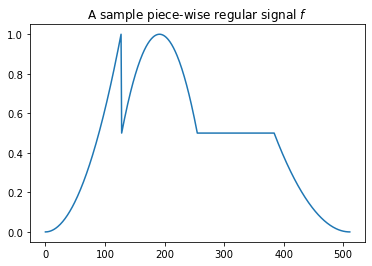

In [322]:
# Make a piece-wise regular signal.
f = np.zeros(n)
f[: n // 4] = np.linspace(0, 1, n // 4) ** 2
f[n // 4 : 2 * n // 4] = 1 - 0.5 * np.linspace(-1, 1, n // 4) ** 2
f[2 * n // 4 : 3 * n // 4] = 0.5
f[3 * n // 4 :] = 0.5 * np.linspace(-1, 0, n // 4) ** 2

# Plot it.
plt.title("A sample piece-wise regular signal $f$")
plt.plot(f)
plt.show()

### Performing one pass of the Haar transform.

The Haar transform operates over $j_{max} = \log_2(n)-1$ scales. It computes a series of coarse scale and fine scale coefficients $a_j, d_j\in\mathbb R^{n_j}$ where $n_j=2^j$.

In [323]:
# The Haar transform operates decomposition starting at the `j_max`-th level.
j_max = int(np.log2(n) - 1)

For now, let's compute the first step, at scale $j_{max}$. We initialize the algorithm with $a_{j_{max} + 1} = f$ and aim to compute $a_{j_{max}}$ and $d_{j_{max}}$.

As seen during class, $a_j = (a_{j+1}\star\tilde h)\downarrow_2$ and $d_j = (a_{j+1}\star\tilde g)\downarrow_2$.

Here, $h = [1, 1]/\sqrt 2$ and $g = [-1, 1]/\sqrt 2$ so $a_j[k] = \dfrac{a_{j+1}[2k] + a_{j+1}[2k+1]}{\sqrt 2}$ and $d_j[k] = \dfrac{a_{j+1}[2k] - a_{j+1}[2k+1]}{\sqrt 2}$

**Question 1:** Implement a function performing one pass of the Haar transform

In [324]:
# The Haar transform is a simple averaging and differencing operation.
def haar(a):
    coarse = (a[::2] + a[1::2])/np.sqrt(2) # average
    detail = (a[::2] - a[1::2])/np.sqrt(2) # difference
    return coarse, detail

Let's visualize the original signal $f$ and the decomposition $a_{j_{max}}\cup d_{j_{max}}$.

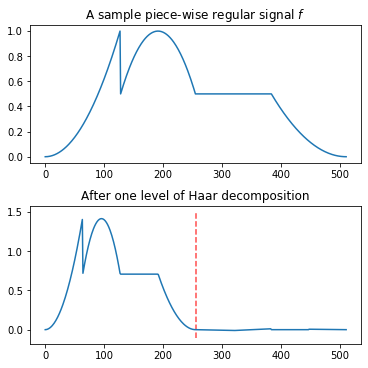

In [325]:
# Initialize the subplots.
fig, axes = plt.subplots(2, 1, figsize=(5, 5), constrained_layout=True)

# Plot the original signal.
axes[0].set_title("A sample piece-wise regular signal $f$")
axes[0].plot(f)

# Plot the first pass of Haar transform.
axes[1].set_title("After one level of Haar decomposition")
axes[1].plot(np.concatenate(haar(f)))
axes[1].vlines(n // 2, -0.1, 1.5, color="red", alpha=0.7, linestyle="--")

# Display the plot
plt.show()


### Performing a full Haar transform

**Question 2:** Now that you managed to do one pass, perform the full Haar transform!

You can discard all the intermediary coarse approximations except the last one ($a_{j_{min}}$).

Save the details $d_j$ in a dictionary object called `details_history`, we'll need them later.

In [326]:
coarse = f.copy() # Initialize the coarse approximation.
details_history = {} # Initialize the details history.
j_max, j_min = 8, 0 # Define the maximum and minimum scales.

# Loop over the scales.
for i, j in enumerate(range(j_max, j_min - 1, -1)):
    coarse, details_history[j] = haar(coarse)

**Question 3:** Visualize the detail coefficients for different scales.

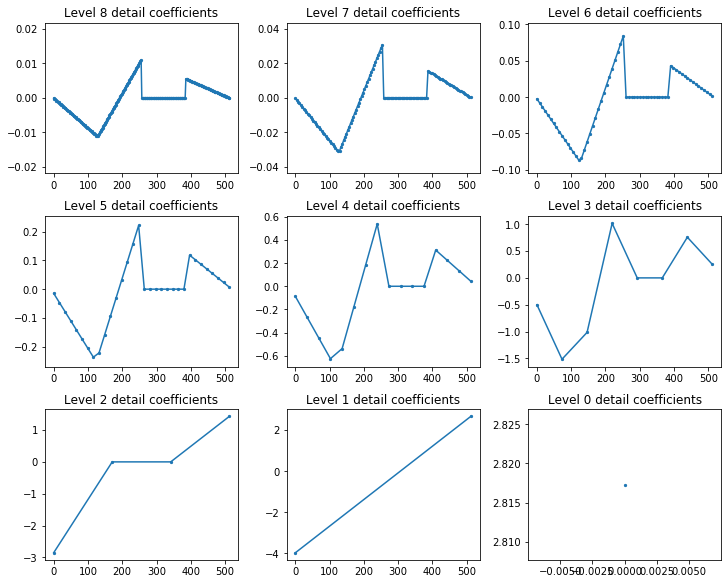

In [327]:
# Initialize the subplots.
fig, axes = plt.subplots(3, 3, figsize=(10, 8), constrained_layout=True)

# Loop over the scales.
for i, j in enumerate(range(j_max, j_min - 1, -1)):

    # Plot the details.
    axes.ravel()[i].set_title(f"Level {j} detail coefficients")
    axes.ravel()[i].scatter(np.linspace(0, n, 2**j), details_history[j], s=5)
    axes.ravel()[i].plot(np.linspace(0, n, 2**j), details_history[j])

# Display the plot.
plt.show()


**Question 3:** Concatenate the different vectors to get the Haar transform $\mathcal H f=a_0 \cup_j d_j$ and visualize it. Verify the conservation of energy $||\mathcal H f||_2 = ||f||_2$

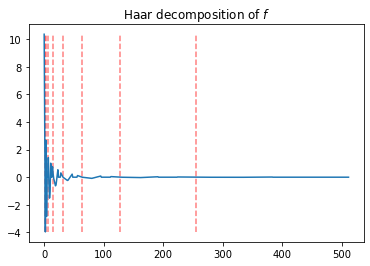

In [328]:
# Concatenate the details and coarse approximation.
f_transformed = coarse.copy()
for j in range(j_min, j_max+1):
    f_transformed = np.concatenate((f_transformed, details_history[j]))

# Define the red lines.
vlines = [1]
for i in range(1, j_max):
    vlines.append(vlines[-1] + 2**i)

# Plot the transformed signal and the red lines.
plt.title("Haar decomposition of $f$")
plt.plot(f_transformed)
plt.vlines(
    vlines,
    f_transformed.min(),
    f_transformed.max(),
    color="r",
    linestyle="--",
    alpha=0.5,
)
plt.show()


In [329]:
norm_f = np.linalg.norm(f) # Compute the norm of the original signal.
norm_f_transformed = np.linalg.norm(f_transformed) # Compute the norm of the transformed signal.
norm_diff = (norm_f - norm_f_transformed) / norm_f # Compute the relative difference.
print(f"Difference in norms (should be 0): {norm_diff}") # Print the relative difference.

Difference in norms (should be 0): 5.695427817388382e-16


### Performing the inverse 1-D Haar Transform

A pass of inverse Haar transform is defined by $a_{j+1} = (a_{j}\uparrow^2) \star h + (d_{j}\uparrow^2) \star g$.

Here, this means $a_{j+1}[2k] = \dfrac{a_{j}[k] + d_{j}[k]}{\sqrt 2}$ and $a_{j+1}[2k+1] = \dfrac{a_{j}[k] - d_{j}[k]}{\sqrt 2}$.

 **Question 4:** Implement a function performing one pass of inverse Haar transform. Then using the previously computed objects `coarse` and `details_history`, compute the reconstruction at different scales. Check that the final reconstruction matches the original signal.

In [330]:
def ihaar(coarse, details):
    a = np.zeros(2 * len(coarse)) # Initialize the array.
    a[::2] = (coarse + details) / np.sqrt(2) # average
    a[1::2] = (coarse - details) / np.sqrt(2) # difference
    return a

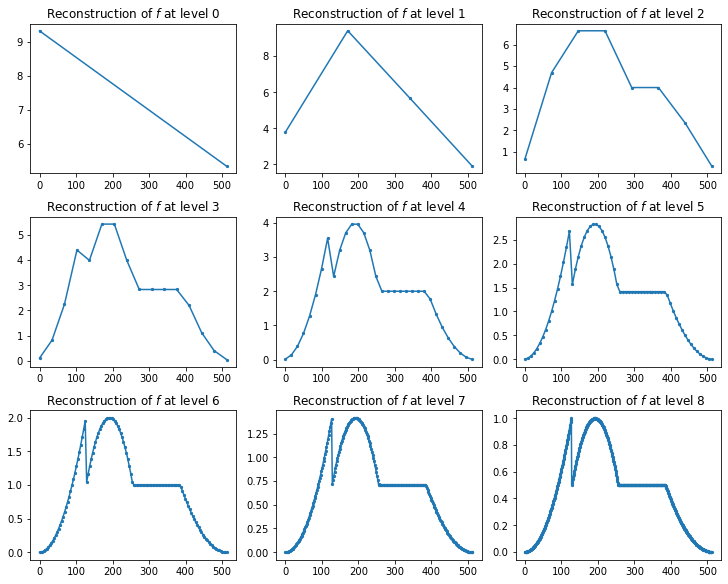

In [331]:
a = coarse.copy() # Initialize the inverse Haar transform algorithm.
j_max, j_min = 8, 0 # Define the scales to compute over.

# Initialize the subplots.
fig, axes = plt.subplots(3, 3, figsize=(10, 8), constrained_layout=True)

# Loop over the scales.
for i, j in enumerate(range(j_min, j_max + 1)):

    # Compute the reconstruction.
    a = ihaar(a, details_history[j])

    # Plot the reconstruction.
    axes.ravel()[i].set_title("Reconstruction of $f$ at level %d" % j)
    axes.ravel()[i].scatter(np.linspace(0, n, len(a)), a, s=5)
    axes.ravel()[i].plot(np.linspace(0, n, len(a)), a)

# Display the figure.
plt.show()

In [332]:
print(
    "Diff between original and reconstructed signal (should be 0)",
    np.linalg.norm(f - a) / np.linalg.norm(f),
)


Diff between original and reconstructed signal (should be 0) 1.2126724165579614e-15


## 2-D Haar Transform

Congrats for making it this far :) Let's extend this to a 2D signal, i.e. an image. The main inution here is that we will alternate between applying the Haar transform on the rows and on the columns of the image.

### Loading a 2-D signal (an image!)

In [333]:
# Loading the image.
f = astronaut()

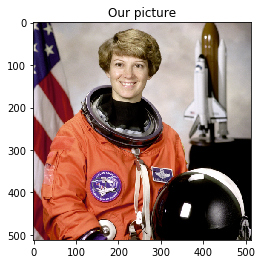

In [334]:
# To plot an image, use `plt.imshow`.
plt.imshow(f)
plt.title("Our picture")
plt.show()

In [335]:
# Resizing the image.
f = resize(f, (n, n))

# Converting the image to grayscale.
f = rgb2gray(f)

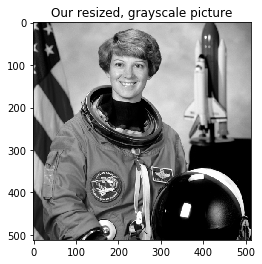

In [336]:
# Tip: to plot a grayscale image in gray instead of the default green, use `cmap="gray"`.
plt.imshow(f, cmap="gray")
plt.title("Our resized, grayscale picture")
plt.show()

### Performing one pass of vertical Haar transform

The first step apply a vertical transformation, which corresponds to applying a 1-D Haar transform on each column.

$$a_j[k, \cdot] \in\mathbb R^{n\times n} \mapsto \dfrac{a_{j+1}[2k, \cdot] + a_{j+1}[2k+1, \cdot]}{\sqrt 2} ~,~ \dfrac{a_{j+1}[2k, \cdot] - a_{j+1}[2k+1, \cdot]}{\sqrt 2}$$

**Question 5:** Implement a function performing one vertical pass of the Haar transform.

In [337]:
def vertical_haar(a):
    coarse = (a[::2, :] + a[1::2, :])/np.sqrt(2) # average
    detail = (a[::2, :] - a[1::2, :])/np.sqrt(2) # difference
    return coarse, detail

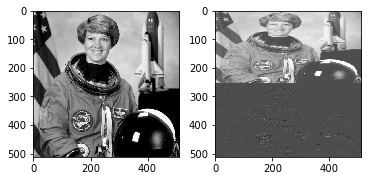

In [338]:
# Display the image and one pass of vertical Haar transform.
fig, axes = plt.subplots(1, 2, figsize=(5, 3), constrained_layout=True)
axes[0].imshow(f, cmap="gray")
axes[1].imshow(np.vstack(vertical_haar(f)), cmap="gray")
plt.show()

### Performing one pass of horizontal Haar transform

**Question 6:** Do the same thing for the horizontal case.

In [339]:
def horizontal_haar(a):
    # We can reuse the vertical Haar transform function.
    coarse, detail = vertical_haar(a.T)
    return coarse.T, detail.T

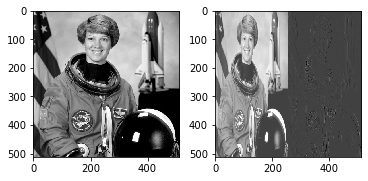

In [340]:
# Display the image and one pass of horizontal Haar transform.
fig, axes = plt.subplots(1, 2, figsize=(5, 3), constrained_layout=True)
axes[0].imshow(f, cmap="gray")
axes[1].imshow(np.hstack(horizontal_haar(f)), cmap="gray")
plt.show()

### Combining the vertical and horizontal transforms

Combining the vertical and horizontal transforms will allow us to define vertical, horizontal and diagonal detail coefficients:
$$a_j,d^H_j,d^V_j,d^D_j$$
through the formulas
$$
\tilde a_j, \tilde d_j = \mathcal H^V(a_{j+1})\\
a_j, d^H_j = \mathcal H^H(\tilde a_j)\\
d^V_j, d^D_j = \mathcal H^H(\tilde d_j)\\
$$

**Question 7:** Perform one pass of the Haar transform by computing $a_{j_{max}},d^H_{j_{max}},d^V_{j_{max}},d^D_{j_{max}}$.

In [341]:
# Perform one pass of the Haar transform.
coarse, detail = vertical_haar(f)
coarse, detail_horizontal = horizontal_haar(coarse)
detail_vertical, detail_diagonal = horizontal_haar(detail)

Analogously to before, we can define the transformed signal as below.

In [342]:
# Assemble the transformed signal.
transformed = np.vstack(
    (
        np.hstack((coarse, detail_horizontal)),
        np.hstack((detail_vertical, detail_diagonal)),
    )
)

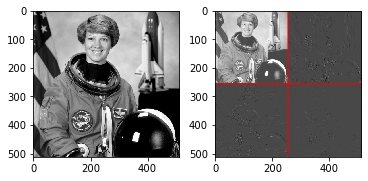

In [343]:
# Display the original and transformed signals.
fig, axes = plt.subplots(1, 2, figsize=(5, 3), constrained_layout=True)
axes[0].imshow(f, cmap="gray")
axes[1].imshow(transformed, cmap="gray")
axes[1].vlines(n // 2, 0, n - 1, color="r", alpha=0.7)
axes[1].hlines(n // 2, 0, n - 1, color="r", alpha=0.7)
plt.show()

### Performing the full 2-D Haar transform

**Question 7:** Perform a full 2D Haar transform of the image and display the transform. Display the horizontal, vertical an diagonal details at level 6. Check the conservation of energy.

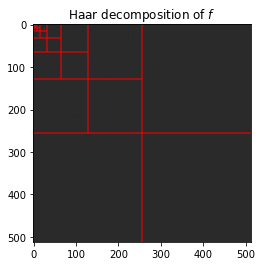

In [344]:
# As before, we keep an history of the details because we'll need them to invert the transform.
details_vertical_history = {}
details_horizontal_history = {}
details_diagonal_history = {}

coarse = f.copy() # Initialize the coarsest scale.
j_max, j_min = 8, 0 # Define the scales to compute over.

# Initialize the transformed image and red lines.
transformed, vlines = np.zeros_like(coarse), []

# Loop over the scales.
for j in range(j_max, j_min - 1, -1):

    # Compute the Haar transform.
    coarse, detail = vertical_haar(coarse)
    coarse, details_horizontal_history[j] = horizontal_haar(coarse)
    details_vertical_history[j], details_diagonal_history[j] = horizontal_haar(detail)

    # Update the transformed image.
    transformed[
        2**j : 2 ** (j + 1), 2**j : 2 ** (j + 1)
    ] = details_diagonal_history[j]
    transformed[2**j : 2 ** (j + 1), 0 : 2**j] = details_vertical_history[j]
    transformed[0 : 2**j, 2**j : 2 ** (j + 1)] = details_horizontal_history[j]

    # Plot some red lines.
    plt.vlines(2**j, 0, 2 ** (j + 1), color="r", alpha=0.7)
    plt.hlines(2**j, 0, 2 ** (j + 1), color="r", alpha=0.7)

# Add the last coarse approximation in the corner.
transformed[0 : 2**j_min, 0 : 2**j_min] = coarse

# Plot the transformed image.
plt.title("Haar decomposition of $f$")
plt.imshow(transformed, cmap="gray")
plt.show()


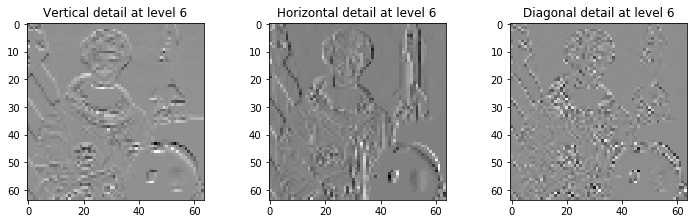

In [345]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3), constrained_layout=True)

axes[0].set_title("Vertical detail at level 6")
axes[0].imshow(details_vertical_history[6], cmap="gray")

axes[1].set_title("Horizontal detail at level 6")
axes[1].imshow(details_horizontal_history[6], cmap="gray")

axes[2].set_title("Diagonal detail at level 6")
axes[2].imshow(details_diagonal_history[6], cmap="gray")

plt.show()

In [346]:
print(
    "Difference between norms (should be 0):",
    (np.linalg.norm(f) - np.linalg.norm(transformed)) / np.linalg.norm(f),
)


Difference between norms (should be 0): 1.3364150672529436e-13


### Performing the inverse 2-D Haar Transform

As for the direct 2D transform, we will alternate between horizontal and vertical inverse transforms through the formulas
$$
\tilde a_j = \mathcal (H^H)^{-1}(a_{j}, d^H_{j})\\
\tilde d_j = \mathcal (H^H)^{-1}(d^V_{j}, d^D_{j})\\
a_{j+1} = \mathcal (H^V)^{-1}(\tilde a_j, \tilde d_j)\\
$$

**Question 8:** Perform a full inverse 2D Haar transform of the image and display the reconstructions. Check that the final recontruction matches the original signal.

In [347]:
def inverse_haar_vertical(coarse, details):
    a = np.zeros((2*coarse.shape[0], coarse.shape[1]))
    a[::2, :] = (coarse + details)/np.sqrt(2) # average
    a[1::2, :] = (coarse - details)/np.sqrt(2) # difference
    return a


In [348]:
def inverse_haar_horizontal(coarse, details):
    # We can reuse the vertical Haar transform function.
    return inverse_haar_vertical(coarse.T, details.T).T


In [316]:
def inverse_haar(coarse, detail_horizontal, detail_vertical, detail_diagonal):
    return inverse_haar_vertical(
        inverse_haar_horizontal(coarse, detail_horizontal),
        inverse_haar_horizontal(detail_vertical, detail_diagonal),
    )


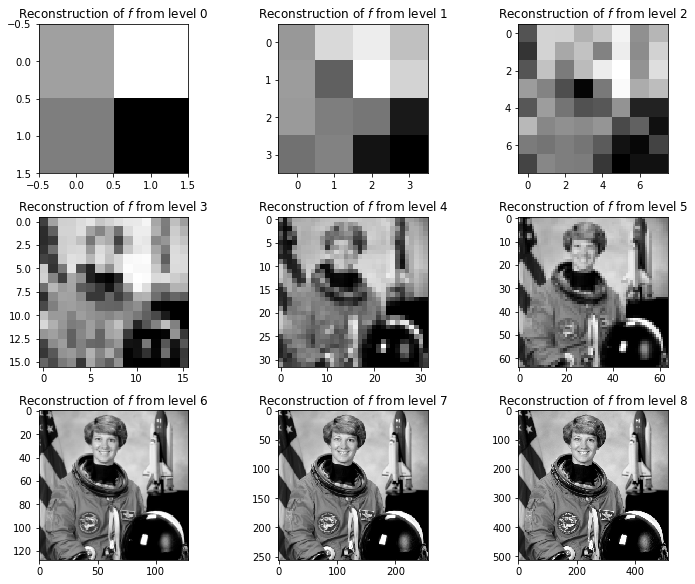

In [349]:
a = coarse.copy() # Initialize the coarsest scale.
j_max, j_min = 8, 0 # Define the scales to compute over.

# Initialize the subplots.
fig, axes = plt.subplots(3, 3, figsize=(10, 8), constrained_layout=True)

# Loop over the scales.
for i, j in enumerate(range(j_min, j_max + 1)):

    # Compute the inverse Haar transform.
    a = inverse_haar(
        a,
        details_horizontal_history[j],
        details_vertical_history[j],
        details_diagonal_history[j],
    )

    # Plot the reconstruction.
    axes.ravel()[i].set_title("Reconstruction of $f$ from level %d" % j)
    axes.ravel()[i].imshow(a, cmap="gray")

# Display the figure.
plt.show()


In [350]:
print(
    "Difference between image and reconstruction (should be 0):",
    (np.linalg.norm(f - a) / np.linalg.norm(f)),
)


Difference between image and reconstruction (should be 0): 2.3508669482933283e-15
